# lightcurves

> Modeling and parameter extraction of lightcurves

In [1]:
#| default_exp lightcurves

In [ ]:
#| hide
from nbdev.showdoc import *

In [1]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from scipy.integrate import quad, nquad
from scipy.optimize import fsolve
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from fastcore.test import *

from abc import ABC, abstractmethod

In [3]:
#Nothing implemented yet, just a dump for future work

def A_ps(u):
    return (u**2 + 2) / (u * (u**2 + 4)**(1/2))

def f_func(x):
    return (2 + x)/(x*(4+x))**(0.5) - 1

def t_fwhm_gondolo(t_e, umin):
    deltab = f_func(umin**2)
    bw2 = 2* f_func(deltab)
    w_b = 2*(bw2 - umin**2)**(1/2)
    return w_b * t_e

def t_E_from_t_fwhm(t_fwhm, umin):
    deltab = f_func(umin**2)
    bw2 = 2* f_func(deltab)
    w_b = 2*(bw2 - umin**2)**(1/2)
    return t_fwhm / w_b

def ellip(phi, m):
    return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]

def theta_max(u, rho):
    if u <= rho:
        return np.pi/2
    else:
        return np.arcsin(rho/u)

def A_gould(u, rho):
    return A_ps(u) * 4*u / (np.pi * rho) * ellip(theta_max(u, rho), u/rho)

def f_func_finite(u, rho):
    return A_gould(u, rho) - 1

def t_fwhm_gondolo(t_e, umin):
    deltab = f_func(umin**2)
    bw2 = 2* f_func(deltab)
    w_b = 2*(bw2 - umin**2)**(1/2)
    return w_b * t_e

def t_fwhm_gondolo_finite(t_e, umin, rho):
    func = lambda b: f_func_finite(b,rho) - f_func_finite(umin**2,rho)*0.5
    bw = fsolve(func,1)[0]
    w_b = 2*(bw**2 - umin**2)**(1/2)
    return w_b * t_e

# def t_E_from_t_fwhm_finite(t_fwhm, umin, rho):
#     if rho >=10:
#         return t_fwhm/rho/2
#     func = lambda b: f_func_finite(b,rho) - f_func_finite(umin**2,rho)*0.5
#     bw = fsolve(func,1)[0]
#     w_b = 2*(bw**2 - umin**2)**(1/2)
#     return t_fwhm / w_b

def t_E_from_t_fwhm_finite(t_fwhm, umin, rho):
    if rho >=1:
        return t_fwhm/rho/2
    return t_E_from_t_fwhm(t_fwhm, umin)

def magnification_finite_new(u, rho):
    integrand = lambda r, theta: integrand_polar(r, theta, u)
    result, _ = nquad(integrand, [[0, rho], [0, 2 * np.pi]])
    return result / (np.pi * rho**2)
    
def u_fwhm_func(rho, umin):
    Amax = magnification_finite_new(umin, rho)
    func = lambda u: magnification_finite_new(u, rho) - (1+(1-Amax)/2)
    return fsolve(func, 1, xtol=1e-2)[0]

def t_duration(t_e, umin, finite, rho=None, ut=1):
    if not finite:
        return 2*(ut**2 - umin**2)**(1/2) * t_e
    else:
        if ut_func_new(rho, 1.34)[0] <= umin:
            return 0
        return (2*(ut_func_new(rho, 1.34)**2 - umin**2)**(1/2) * t_e)[0]


In [11]:
u_vals = np.logspace(-2, 1, 30)
rho_vals = np.logspace(-2, 1, 30)
z_vals = np.array([[magnification_finite_new(u, rho) for u in u_vals] for rho in tqdm(rho_vals)])
mag_finite_interp = RegularGridInterpolator((rho_vals, u_vals), z_vals, method='linear', bounds_error=False, fill_value=None)

def fast_magnification_finite_new(u, rho):
    return mag_finite_interp([float(rho), float(u)])
    
def fast_u_fwhm_func(rho, umin):
    Amax = fast_magnification_finite_new(umin, rho)
    if Amax<1:
        return 0
    func = lambda u: fast_magnification_finite_new(u, rho) - (1+(Amax-1)/2)
    return fsolve(func, 1)

# z_u_vals = np.array([[fast_u_fwhm_func(rho, u) for u in u_vals] for rho in tqdm(rho_vals)])
# u_fwhm_interp = RegularGridInterpolator((rho_vals, u_vals), z_u_vals, method='linear', bounds_error=False, fill_value=None)


  0%|          | 0/30 [00:00<?, ?it/s]

 50%|█████     | 15/30 [00:20<00:37,  2.47s/it]

In [ ]:
fast_u_fwhm_func(1, 0.5)

In [7]:
def t_fwhm(t_e, umin, finite, rho=None, ut=1):
    if not finite:
        return t_fwhm_gondolo(t_e, umin)
    else:
        Amax = 1 + 1/rho
        u_fwhm = u_fwhm_interp([rho, umin])[0]
        if u_fwhm<=umin:
            return 0
        return 2*(u_fwhm**2 - umin**2)**(1/2) * t_e
    
def t_e_from_fwhm(t_fwhm, umin, finite, rho=None, ut=1):
    if not finite:
        return t_fwhm / t_fwhm_gondolo(1, umin)
    else:
        u_fwhm = u_fwhm_interp([rho, umin])[0]
        if u_fwhm<=umin:
            print('u_fwhm<=umin')
            return 1e-3
        return t_fwhm / (2*(u_fwhm**2 - umin**2)**(1/2))
    

In [8]:
umin_arr = np.logspace(-1, 0.4, 100)
rho= 1
fast_Amax_arr = np.array([fast_magnification_finite_new(umin, rho) for umin in umin_arr])

fast_uhm_arr = np.array([u_fwhm_interp([rho, umin]) for umin in umin_arr])
ut_arr = np.array([ut_func_new(1.2, Amax) for Amax in fast_Amax_arr])
uhm_arr = np.array([ut_func_new(1.2, 1+(Amax-1)/2) for Amax in fast_Amax_arr])
uhm_point_arr = np.array([(2* f_func(f_func(umin**2)))**(1/2) for umin in umin_arr])

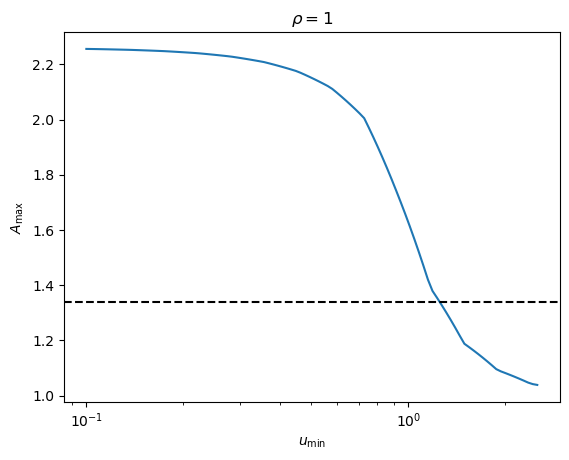

In [9]:
# plt.plot(umin_arr, Amax_arr)
plt.plot(umin_arr, fast_Amax_arr)
plt.axhline(1.34, color='k', linestyle='--')
plt.xlabel(r'$u_{\rm min}$')
plt.ylabel(r'$A_{\rm max}$')
plt.title(r'$\rho = $' + str(rho))
plt.xscale('log')
plt.show()

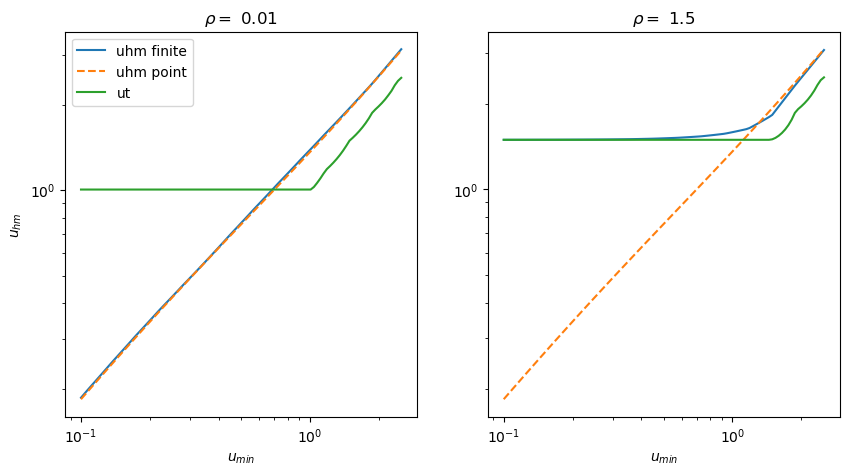

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(121)

rho= 0.01
fast_uhm_arr = np.array([u_fwhm_interp([rho, umin])[0] for umin in umin_arr])
uhm_point_arr = np.array([(2* f_func(f_func(umin**2)))**(1/2) for umin in umin_arr])
fast_Amax_arr = np.array([fast_magnification_finite_new(umin, rho) for umin in umin_arr])
ut_arr = np.array([ut_func_new(rho, Amax) for Amax in fast_Amax_arr])
plt.plot(umin_arr, fast_uhm_arr, label='uhm finite')
plt.plot(umin_arr, uhm_point_arr, label='uhm point', linestyle='--')
plt.plot(umin_arr, ut_arr, label='ut')

plt.xlabel(r'$u_{min}$')
plt.ylabel(r'$u_{hm}$')
plt.title(r'$\rho = $ ' + str(rho))
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.subplot(122)
rho= 1.5
fast_uhm_arr = np.array([u_fwhm_interp([rho, umin])[0] for umin in umin_arr])
uhm_point_arr = np.array([(2* f_func(f_func(umin**2)))**(1/2) for umin in umin_arr])
fast_Amax_arr = np.array([fast_magnification_finite_new(umin, rho) for umin in umin_arr])
ut_arr = np.array([ut_func_new(rho, Amax) for Amax in fast_Amax_arr])
plt.plot(umin_arr, fast_uhm_arr, label='uhm finite')
plt.plot(umin_arr, uhm_point_arr, label='uhm point', linestyle='--')
plt.plot(umin_arr, ut_arr, label='ut')

plt.xlabel(r'$u_{min}$')
plt.title(r'$\rho = $ ' + str(rho))
plt.xscale('log')
plt.yscale('log')
plt.show()


In [13]:
rho = 2.1
# rho = 0.01

ut = 1
umin_arr = np.logspace(np.log10(0.01), np.log10(2), 100)
tfwhm_arr = np.array([t_fwhm(10, umin, True, rho, ut_func_new(rho, 1.34)) for umin in umin_arr])
tfwhm_arr_point = np.array([t_fwhm(10, umin, False, rho, ut_func_new(rho, 1.34)) for umin in umin_arr])
t_duration_arr = np.array([t_duration(10, umin, True, rho,  1) for umin in umin_arr])

rho_arr = np.linspace(0.01, 3, 100)
tfwhm_arr2 = np.array([t_fwhm(10, 0.1, True, rho, ut_func_new(rho, 1.34)) for rho in rho_arr])
tfwhm_arr_point2 = np.array([t_fwhm(10, 0.1, False, rho, ut_func_new(rho, 1.34)) for rho in rho_arr])
t_duration_arr2 = np.array([t_duration(10, 0.1, True, rho, 1) for rho in rho_arr])

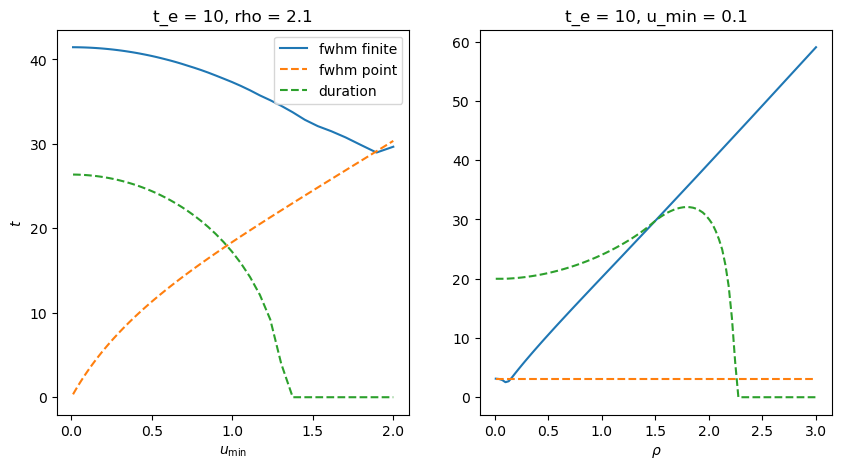

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('t_e = 10, rho = {}'.format(rho))

plt.plot(umin_arr, tfwhm_arr, label='fwhm finite')
plt.plot(umin_arr, tfwhm_arr_point, label = 'fwhm point', linestyle='--')
plt.plot(umin_arr, t_duration_arr, label='duration', linestyle='--')
plt.ylabel(r'$t$')
plt.xlabel(r'$u_{\rm min}$')
# plt.xscale('log')
plt.legend()
plt.subplot(122)
plt.plot(rho_arr, tfwhm_arr2)
plt.plot(rho_arr, tfwhm_arr_point2, linestyle='--')
plt.plot(rho_arr, t_duration_arr2, linestyle='--')
plt.title(r't_e = 10, u_min = 0.1')
plt.xlabel(r'$\rho$')
plt.show()

In [15]:
def u_func(umin, t, t_e):
    return np.sqrt(umin**2 + (t/t_e)**2)

def t_fwhm_point(umin, t_e):
    t_vals = np.linspace(-5*t_e, 5*t_e, 2000)
    A_vals = np.array([A_ps(u_func(umin, t, t_e)) for t in t_vals])
    A_max = np.max(A_vals)
    t_0 = t_vals[np.argmax(A_vals)]
    half_max_indices = np.where(np.isclose(A_vals, A_max/2, atol=0.1))[0]
    t_fwhm = t_vals[half_max_indices[-1]] - t_vals[half_max_indices[0]]
    return t_fwhm


def t_fwhm_finite(umin, t_e, rho):
    t_vals = np.linspace(-5*t_e, 5*t_e, 2000)
    A_vals = np.array([A_gould(u_func(umin, t, t_e), rho) for t in t_vals])
    A_max = np.max(A_vals)
    t_0 = t_vals[np.argmax(A_vals)]
    half_max_indices = np.where(np.isclose(A_vals, A_max/2, atol=0.1))[0]
    t_fwhm = t_vals[half_max_indices[-1]] - t_vals[half_max_indices[0]]
    return t_fwhm

In [17]:
umin = 1.2
deltab = f_func(umin**2)
bw2 = 2* f_func(deltab)
print(f_func(umin**2)/f_func(bw2))


1.999999999999998


In [18]:
rho=0.1
t_fwhm_gondolo_finite(1, 0.2, rho)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_83573/3377527036.py:22: RuntimeWarning: invalid value encountered in sqrt
  return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_83573/3377527036.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_83573/3377527036.py:22: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings

1.9595917942265424

In [30]:
umin = 0.2
t_e = 10
t_arr = np.linspace(-20,20,1000)
u_arr = u_func(umin, t_arr, t_e)
rho = 0.7
A_fs_arr = np.array([A_gould(u, rho) for u in u_arr])
A_ps_arr = np.array([A_ps(u) for u in u_arr])

In [31]:
#This is ~ 2*t_E for ut=1 and umin<<1
t_duration(umin, 1, t_e, 0)/t_e

0.003712691344232568

In [32]:
#Novati relating fwhm to t_e for umin << 1
print(np.sqrt(12)*umin*t_e)
#Explicit calculation of fwhm
print(t_fwhm_point(umin, t_e))


6.928203230275509
7.75387693846924


In [33]:
#Finite source calculation, small source
print(t_fwhm_finite(umin, t_e, 0.01))
#Finite source calculation, larger source
print(t_fwhm_finite(umin, t_e, 0.5))

7.75387693846924
13.056528264132062


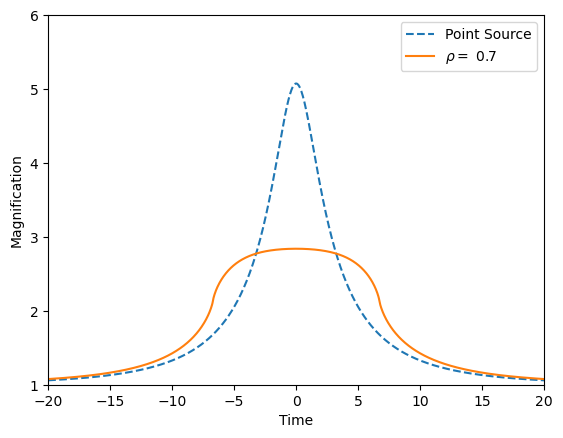

In [34]:
plt.plot(t_arr, A_ps_arr, label=r"Point Source", ls='--')
plt.plot(t_arr, A_fs_arr, label=r"$\rho = $" + ' ' + str(rho))


plt.ylim(1,6)
# plt.ylim(5,50)

plt.xlim(-20,20)
# plt.xlim(-2,2)


plt.xlabel("Time")
plt.ylabel("Magnification")
plt.legend()
# plt.savefig("figures/ps_fs_magnification.pdf")
plt.show()

In [10]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()